In [59]:
import requests
from urllib.parse import urlencode
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import chi2_contingency, chi2

import scipy

from scipy.stats import norm

In [60]:
# Подгрузим фунцию бутсрапа она нам еще пригодится

In [61]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95,  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, replace=True  # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True,
        ).values

        boot_data.append(statistic(samples_1 - samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if (
            abs(bar.get_x()) <= quants.iloc[0][0]
            or abs(bar.get_x()) >= quants.iloc[1][0]
        ):
            bar.set_facecolor("red")
        else:
            bar.set_facecolor("grey")
            bar.set_edgecolor("black")

    plt.style.use("ggplot")
    plt.vlines(quants, ymin=0, ymax=50, linestyle="--")
    plt.xlabel("boot_data")
    plt.ylabel("frequency")
    plt.title("Histogram of boot_data")
    plt.show()

    if p_value < 0.05:
        print("отвергаем нулевую гипотезу")
    else:
        print("принимаем нулевую гипотезу")

    return {"quants": quants, "p_value": p_value}

In [62]:
# выгружаем данные
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
active_users_url = 'https://disk.yandex.ru/d/B4QnY5D5EtKa-A' 
groups_url = 'https://disk.yandex.ru/d/jP_BAw_oxS3law'
purchases_url = 'https://disk.yandex.ru/d/AmucCdboEaowhA'

final_url = base_url + urlencode(dict(public_key=active_users_url))
response = requests.get(final_url)
download_url = response.json()['href']
active_users = pd.read_csv(download_url) # информация о пользователях, которые посещали приложение во время эксперимента. 

final_url = base_url + urlencode(dict(public_key=groups_url))
response = requests.get(final_url)
download_url = response.json()['href']
groups = pd.read_csv(download_url) # разбивка пользователей на контрольную (А) и тестовую (В) группы.

final_url = base_url + urlencode(dict(public_key=purchases_url))
response = requests.get(final_url)
download_url = response.json()['href']
purchases = pd.read_csv(download_url) # данные о транзакциях (оплатах) пользователей приложения во время эксперимента

In [63]:
purchases[purchases["user_id"].isin(groups.user_id)].user_id.count()# все пользователи разбиты на группы

541

In [64]:
purchases[purchases["user_id"].isin(active_users.user_id)].user_id.count()  
# но по 149 пользователям нет данных, кроме суммы вырчуки

392

In [65]:
purchases[purchases["user_id"].isin(groups.user_id)].user_id.count()  # но всем пользователям присвоена группа

541

In [66]:
missing_out = purchases.merge(groups, left_on='user_id', right_on='user_id')
missing_out = missing_out[~missing_out.user_id.isin(active_users.user_id)] 
# посмотрим на всех не попавших в активные пользователей

In [138]:
missing_out

,user_id,revenue,group
1,9000,701.0,B
2,9001,700.0,B
3,9002,702.0,B
5,9003,641.0,B
6,9004,590.0,B
...,...,...,...
508,9144,209.0,B
512,9145,301.0,B
521,9146,207.0,B
530,9147,408.0,B


In [67]:
data = active_users.merge(groups, left_on='user_id', right_on='user_id')
data2 = data.merge(purchases, on='user_id', how='left')
data2 = data2.fillna(0)
# собираем датасет пользователей посещавших наше приложение

In [68]:
data2['segment'] = data2.country + ' ' + data2.platform + ' ' + data2.sex
data2['CR'] = data2.revenue
data2.loc[data2.revenue > 0, 'CR'] = 1
# создадим дополнительные колонки для удобства работы с данными.(я так же проверял данные на нули,
# дупликаты, никаких отклонений)

In [69]:
missing_out.revenue.mean() - data2[data2['revenue'] > 0].revenue.mean() 
# средняя у не заходивших в приложение ниже

-485.04908574167916

In [70]:
missing_out.revenue.median() - data2[data2['revenue'] > 0].revenue.median() 
# медиана у не заходивших в приложение ниже

-300.0

In [71]:
missing_out[missing_out['group'] == 'B'].revenue.mean() - \
data2[(data2['group'] == 'B') & data2['revenue'] > 0 ].revenue.mean()
# средняя у не заходивших в приложение в группе В ниже

-539.025796178344

In [72]:
missing_out[missing_out['group'] == 'B'].revenue.median() - \
data2[(data2['group'] == 'B') & data2['revenue'] > 0 ].revenue.median()
# медиана у не заходивших в приложение в группе В ниже

-451.0

In [73]:
missing_out[missing_out['group'] == 'A'].revenue.mean() - \
data2[(data2['group'] == 'A') & data2['revenue'] > 0 ].revenue.mean()
# средняя у не заходивших в приложение в группе В ниже

-268.9434129089301

In [74]:
missing_out[missing_out['group'] == 'A'].revenue.median() - \
data2[(data2['group'] == 'A') & data2['revenue'] > 0 ].revenue.median()
# медиана у не заходивших в приложение в группе А выше

104.0

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


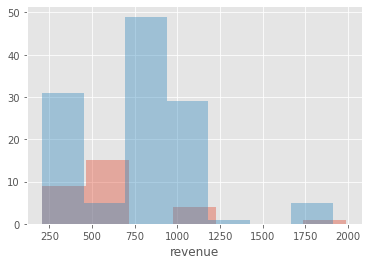

In [196]:
sns.distplot(missing_out[missing_out['group'] == 'A'].revenue, kde=False);\
sns.distplot(missing_out[(missing_out['group'] == 'B')].revenue, kde=False)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


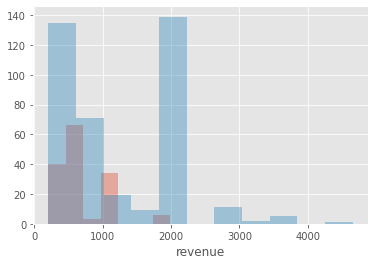

In [75]:
sns.distplot(missing_out.revenue, kde=False); sns.distplot(data2[data2['revenue'] > 0 ].revenue, kde=False);

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


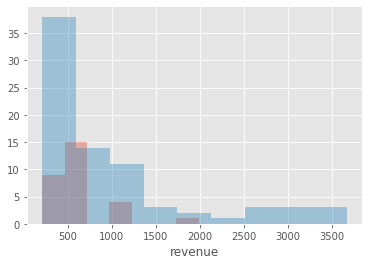

In [76]:
sns.distplot(missing_out[missing_out['group'] == 'A'].revenue, kde=False); sns.distplot(data2[(data2['group'] == 'A') & data2['revenue'] > 0 ].revenue, kde=False)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


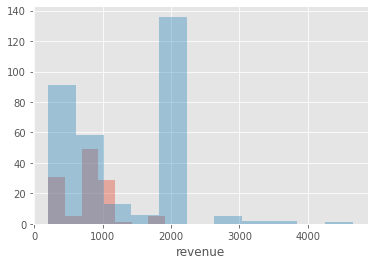

In [77]:
sns.distplot(missing_out[missing_out['group'] == 'B'].revenue, kde=False);\
sns.distplot(data2[(data2['group'] == 'B') & data2['revenue'] > 0 ].revenue, kde=False);

In [78]:
# чеки у не заходивших в приложение в среднем заметно ниже, чем у заходивших

In [79]:
stat, p = scipy.stats.shapiro(missing_out.revenue) # тест Шапиро-Уилк 
alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Отклонить гипотезу о нормальности


In [80]:
stat, p = scipy.stats.normaltest(missing_out.revenue) # Критерий согласия Пирсона

if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Отклонить гипотезу о нормальности


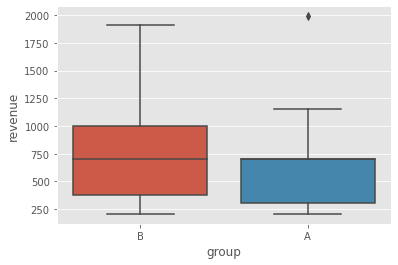

In [81]:
sns.boxplot(x="group", y="revenue", data=missing_out)
# видим разницу в поведении групп, среди пользователей не посещавших приложение

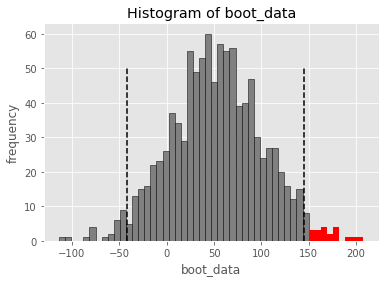

принимаем нулевую гипотезу


{'quants':                 0
 0.025  -41.909583
 0.975  144.795208,
 'p_value': 0.2771063185761645}

In [195]:
get_bootstrap(missing_out[missing_out['group'] == 'B'].revenue, missing_out[missing_out['group'] == 'A'].revenue) 
# так как распределение не нормальное проверим, что средний чек пользователей по группам одинаков
# среди пользователей не заходивших в наше приложение

In [86]:
# видим, что нет статисчтической разницы в средних чеках между 2 группами среди людей не заходивших в наше приложение

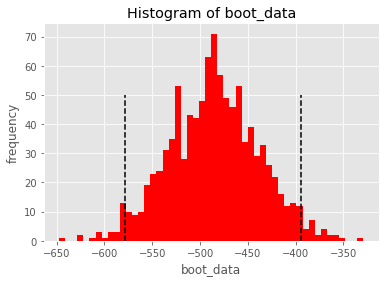

отвергаем нулевую гипотезу


{'quants':                 0
 0.025 -578.936033
 0.975 -394.815370,
 'p_value': 4.7848186923480985e-25}

In [87]:
get_bootstrap(missing_out.revenue, data2[data2['revenue'] > 0].revenue) 
# посмотрим одинваковы средние чеки не попавших пользователей с пользователями приложения

In [88]:
# здесь уже заметное различие в среднем чеке, между платящими покупателями в приложении и другими пользователями

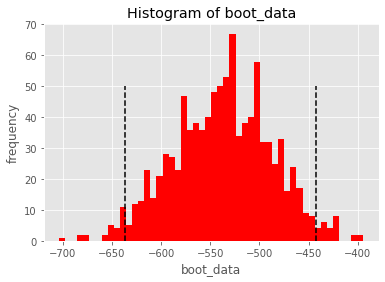

отвергаем нулевую гипотезу


{'quants':                 0
 0.025 -637.195860
 0.975 -442.723567,
 'p_value': 3.1636001213275316e-27}

In [89]:
get_bootstrap(missing_out[missing_out['group'] == 'B'].revenue, \
              data2[(data2['group'] == 'B') & data2['revenue'] > 0 ].revenue) 
# посмотрим одинваковы ли средние чеки платящими пользователями приложения группы В и
# пользователями той же группы, не совершавших покупки в приложении

In [90]:
# разница есть

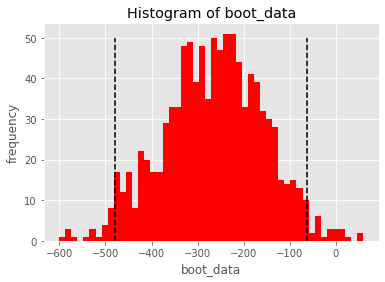

отвергаем нулевую гипотезу


{'quants':                 0
 0.025 -479.567949
 0.975  -62.003205,
 'p_value': 0.014708019276003669}

In [91]:
get_bootstrap(missing_out[missing_out['group'] == 'A'].revenue, \
              data2[(data2['group'] == 'A') & data2['revenue'] > 0 ].revenue) 
# посмотрим одинваковы ли средние чеки платящими пользователями приложения группы А и
# пользователями той же группы, не совершавших покупки в приложении

In [92]:
# Я предполагаю, что 149 пользователей сделали оплату в нашем приложении, не посещая его
# Либо у нас ошибка в логировании. 
# Мы видим, что поведение этой группы статичстически отлично от поведения остальных пользователей
# Их чеки в среднем меньше, чем у других пользователей
# мы не будем их использовать в дальнейшем исследовании ибо они имеют другую модель поведения,
# чем пользователи приложения
# Можем только предположить, что на них не повлияло наше А/В тестирование

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

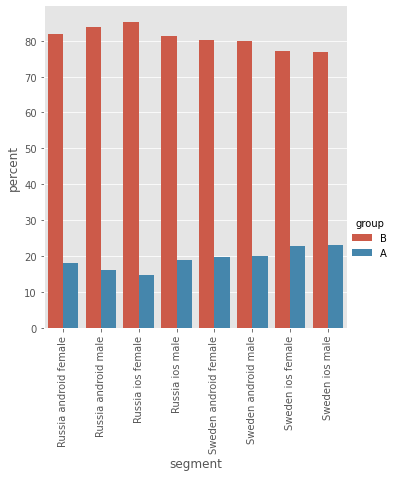

In [93]:
x,y = 'segment', 'group'

(data2
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
plt.xticks(rotation=90)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

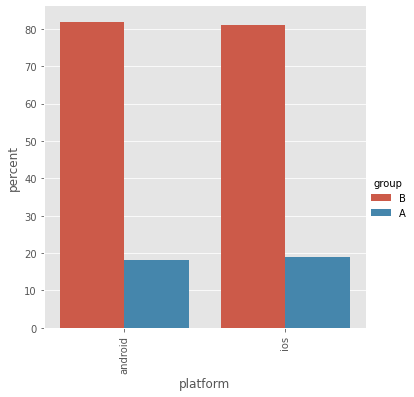

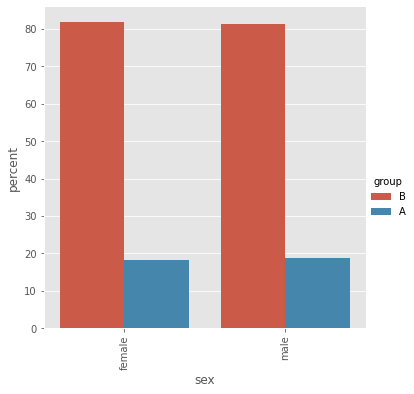

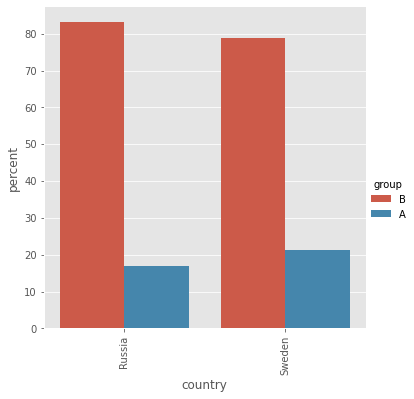

In [94]:
x,y = 'platform', 'group'

(data2
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
plt.xticks(rotation=90);

x,y = 'sex', 'group'

(data2
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
plt.xticks(rotation=90);

x,y = 'country', 'group'

(data2
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
plt.xticks(rotation=90)

In [95]:
# смотрим, прошло ли сплитование правильно, в швеции больше людей попало в группу А, проверим 
# есть ли разница между поведением швецких пользователей и других пользователй

In [96]:
data2[data2['country'] == 'Sweden'].groupby('group').CR.sum()
# посмотрели, что у нас достаточно наблюдений, чтобы провести ztest или хи-квадрат

group
A     35.0
B    117.0
Name: CR, dtype: float64

In [143]:
info1 = [data2[(data2['country'] == 'Sweden')].CR.sum(), \
         data2[(data2['country'] == 'Sweden')].CR.count()]
         
info2 = [data2[(data2['country'] != 'Sweden')].CR.sum(), \
         data2[(data2['country'] != 'Sweden')].CR.count()]

info = [info1, info2]
stat, p, dof, expected = chi2_contingency(info)
print(stat)
print(p)

prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('отвергаем нулевую гипотезу, что конверсия не зависит от страны')
else:
    print('принимаем нулевую гипотезу, что конверсия не зависит от страны')
    

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('отвергаем нулевую гипотезу, что конверсия не зависит от страны')
else:
    print('принимаем нулевую гипотезу, что конверсия не зависит от страны')   

1.9687601944157496
0.16057952184231405
принимаем нулевую гипотезу, что конверсия не зависит от страны
принимаем нулевую гипотезу, что конверсия не зависит от страны


In [146]:
info1 = [data2[(data2['country'] == 'Sweden') & (data2['group'] == 'B')].CR.sum(), \
         data2[(data2['country'] == 'Sweden') & (data2['group'] == 'B')].CR.count()]
         
info2 = [data2[(data2['country'] != 'Sweden') & (data2['group'] == 'B')].CR.sum(), \
         data2[(data2['country'] != 'Sweden') & (data2['group'] == 'B')].CR.count()]

info = [info1, info2]
stat, p, dof, expected = chi2_contingency(info)
print(stat)
print(p)

prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('отвергаем нулевую гипотезу, что конверсия в группе В не зависит от страны')
else:
    print('принимаем нулевую гипотезу, что конверсия в группе В не зависит от страны')
    

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('отвергаем нулевую гипотезу, что конверсия в группе В не зависит от страны')
else:
    print('принимаем нулевую гипотезу, что конверсия в группе В не зависит от страны')  

1.3034393090669916
0.2535859486628833
принимаем нулевую гипотезу, что конверсия в группе В не зависит от страны
принимаем нулевую гипотезу, что конверсия в группе В не зависит от страны


In [147]:
info1 = [data2[(data2['country'] == 'Sweden') & (data2['group'] == 'A')].CR.sum(), \
         data2[(data2['country'] == 'Sweden') & (data2['group'] == 'A')].CR.count()]
         
info2 = [data2[(data2['country'] != 'Sweden') & (data2['group'] == 'A')].CR.sum(), \
         data2[(data2['country'] != 'Sweden') & (data2['group'] == 'A')].CR.count()]

info = [info1, info2]
stat, p, dof, expected = chi2_contingency(info)
print(stat)
print(p)

prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('отвергаем нулевую гипотезу, что конверсия в группе A не зависит от страны')
else:
    print('принимаем нулевую гипотезу, что конверсия в группе A не зависит от страны')
    

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('отвергаем нулевую гипотезу, что конверсия в группе A не зависит от страны')
else:
    print('принимаем нулевую гипотезу, что конверсия в группе A не зависит от страны')  

0.41900020939393445
0.517436342341873
принимаем нулевую гипотезу, что конверсия в группе A не зависит от страны
принимаем нулевую гипотезу, что конверсия в группе A не зависит от страны


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


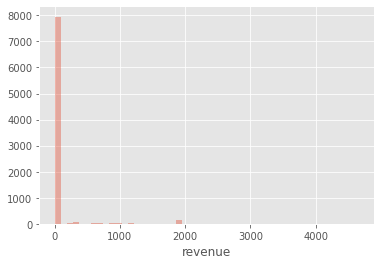

In [148]:
sns.distplot(data2.revenue, kde=False)  # посмотрели, нормальное ли распределение

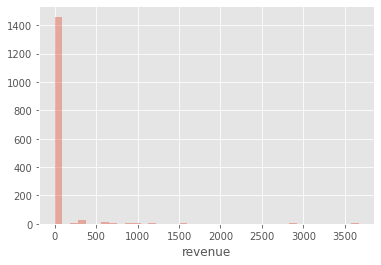

In [149]:
sns.distplot(data2[data2['group'] == 'A'].revenue, kde=False)

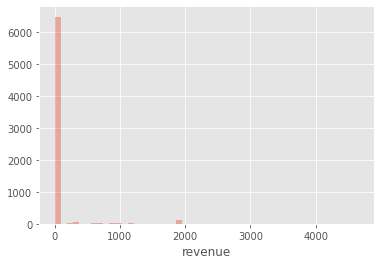

In [150]:
sns.distplot(data2[data2['group'] == 'B'].revenue, kde=False)

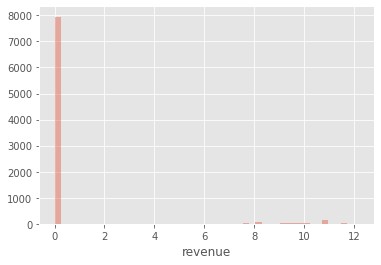

In [151]:
sns.distplot(np.log2(data2.revenue + 1), kde=False)  # логарифмирование не помогает нормализовать распределение

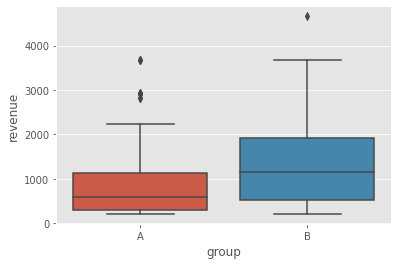

In [152]:
sns.boxplot(x="group", y="revenue", data=data2[(data2['CR'] == 1)])  # посмотрели на выбросы, они не такие большие.

In [153]:
# так как распределение не нормальное, воспользуемся бустрапом

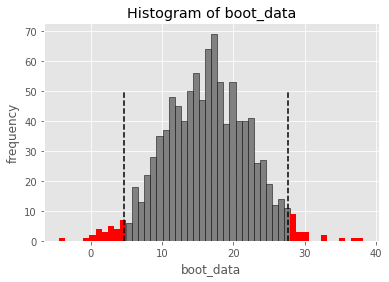

отвергаем нулевую гипотезу


{'quants':                0
 0.025   4.709895
 0.975  27.738996,
 'p_value': 0.005978637324351899}

In [154]:
get_bootstrap(data2[data2['country'] == 'Sweden'].revenue, data2[data2['country'] != 'Sweden'].revenue) 
# одинаков ли средний чек пользователей в Швеции и других стран

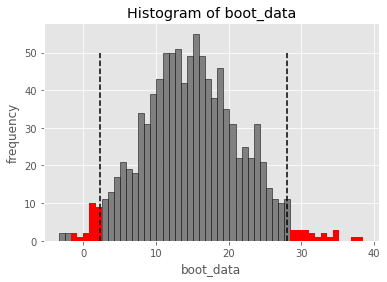

отвергаем нулевую гипотезу


{'quants':                0
 0.025   2.276636
 0.975  28.039203,
 'p_value': 0.025320194071588448}

In [155]:
get_bootstrap(data2[(data2['country'] == 'Sweden') & (data2['group'] == 'B')].revenue, data2[(data2['country'] != 'Sweden') & (data2['group'] == 'B')].revenue)
# одинаков ли средний чек пользователей в Швеции и других стран в группе B

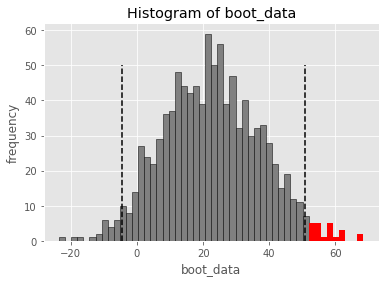

принимаем нулевую гипотезу


{'quants':                0
 0.025  -4.493825
 0.975  50.966612,
 'p_value': 0.12051839856177658}

In [156]:
get_bootstrap(data2[(data2['country'] == 'Sweden') & (data2['group'] == 'A')].revenue, data2[(data2['country'] != 'Sweden') & (data2['group'] == 'A')].revenue)
# одинаков ли средний чек пользователей в Швеции и других стран в группе А

In [157]:
data2[(data2['country'] == 'Sweden') & (data2['group'] == 'A')].CR.sum()
# посомтрели, что у нас достаточно много платящих пользователей из Швеции в контрольной группе, чтобы делать выводы

35.0

In [158]:
# Мы видим, что Швеция отличается по поведению пользователей. В швеции группе B средний чек выше 
# чем у дургих пользователей, при не изменившемся переходе в платящие пользователи
# при этом средний чек и переход в платящие пользователи в контрольной групе не изменился
# Это дает понять, что сплитование на группы у нас прошло относительно нормально, но влияние на средний чек 
# нашего АВ теста в швеции оказалось большее чем в России

In [108]:
data2.groupby('group').CR.sum()  # посмотрели достаточно ли у нас платящих пользователей по группам,
# чтобы можно проводить статистический анализ

group
A     78.0
B    314.0
Name: CR, dtype: float64

In [159]:
# Проверили CR двух груп - пользователей совершивших покупку деленое на всех пользователей

In [160]:
(data2[data2['group'] == 'B']['revenue'] != 0).sum() / data2[data2['group'] == 'B'].user_id.count() * 100

4.615610759958842

In [161]:
(data2[data2['group'] == 'A']['revenue'] != 0).sum() / data2[data2['group'] == 'A'].user_id.count() * 100

5.071521456436931

In [162]:
# в группе А чуть больше конверсия в платящего пользователя
# воспользуемся хиквадратом

In [165]:
info1 = [data2[data2['group'] == 'A'].CR.sum(), \
         data2[data2['group'] == 'A'].CR.count()]
         
info2 = [data2[data2['group'] == 'B'].CR.sum(), \
         data2[data2['group'] == 'B'].CR.count()]

info = [info1, info2]
stat, p, dof, expected = chi2_contingency(info)
print(stat)
print(p)

prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('отвергаем нулевую гипотезу, что конверсия не зависит от группы')
else:
    print('принимаем нулевую гипотезу, что конверсия не зависит от группы')
    

prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('отвергаем нулевую гипотезу, что конверсия не зависит от группы')
else:
    print('принимаем нулевую гипотезу, что конверсия не зависит от группы')

0.43612258061018483
0.5089998823014525
принимаем нулевую гипотезу, что конверсия не зависит от группы
принимаем нулевую гипотезу, что конверсия не зависит от группы


In [115]:
# Мы не можем утверждать, что новая фича значимо влияет на конверсию в покупку.

In [166]:
data2[data2['CR'] == 1].groupby('group').revenue.describe() 
# посмотрели как расперделились продажи среди платящих пользователей, видно
# что почти все параметры кроме минимального чека выросли в группе В

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,78.0,943.564103,919.910874,208.0,300.0,596.0,1125.25,3671.0
B,314.0,1267.875796,790.857880,207.0,520.5,1151.0,1910.00,4660.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


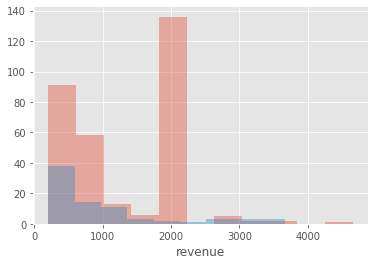

In [167]:
sns.distplot(data2[(data2['group'] == 'B') & (data2['revenue'] > 0)].revenue, kde=False); \
sns.distplot(data2[(data2['group'] == 'A') & data2['revenue'] > 0 ].revenue, kde=False);
# посмотрим как выглядят наша чеки по группам

In [168]:
# Так как распределение не нормальное воспользуемся бутстрапом для определения эффективности 
# новой фичи по среднему значению

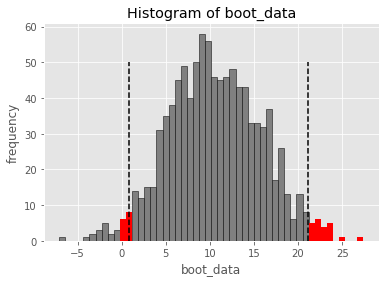

отвергаем нулевую гипотезу


{'quants':                0
 0.025   0.791489
 0.975  21.073442,
 'p_value': 0.042152345672453774}

In [169]:
get_bootstrap(data2[data2['group'] == 'B'].revenue, data2[data2['group'] == 'A'].revenue) 
# одинаковы ли у нас средние чеки в разных группах

In [119]:
# Бутcnрап по среднему показал, что средний чек группе B статистически значимо больше, чем в группе А

In [120]:
# Проверим больше вариантов. Что если рассматривать только платящих пользователей.
# Что если убрать выбросы(хотя их толком и нет, но давайте рассмотрим все варианты, может натолкнемся на инсайт)

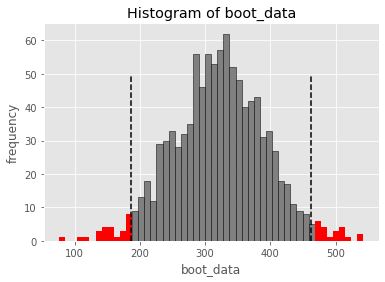

отвергаем нулевую гипотезу


{'quants':                 0
 0.025  186.047293
 0.975  461.963774,
 'p_value': 3.678837809861841e-06}

In [170]:
get_bootstrap(data2[(data2['group'] == 'B') & (data2['revenue'] != 0)].revenue, 
              data2[(data2['group'] == 'A') & (data2['revenue'] != 0)].revenue)
# только платящие пользователи, одинаковые ли средние чеки

In [ ]:
# средние чеки отличаются

In [307]:
# проверим есть ли какая разница в конверсиях в нашем тесте по всем сегментам

In [172]:
# Посмотрим есть ли различия по выручке при сегментации наших пользователей

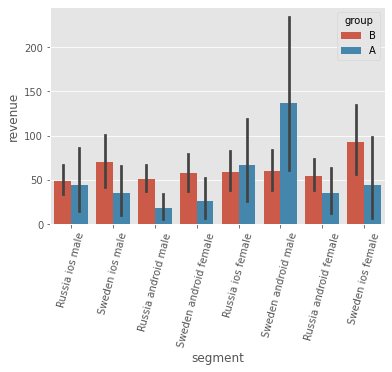

In [197]:
s = sns.barplot(x="segment", y='revenue', hue="group", data=data2)
for item in s.get_xticklabels():
    item.set_rotation(75)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


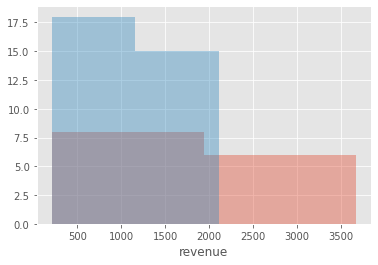

In [203]:
sns.distplot(data2[(data2['segment'] == 'Sweden android male') \
                   & (data2['group'] == 'A') \
                   & (data2['revenue'] > 0)].revenue, \
             kde=False);\
sns.distplot(data2[(data2['segment'] == 'Sweden android male') \
                   & (data2['group'] == 'B')\
                   & (data2['revenue'] > 0)].revenue,\
             kde=False);

In [176]:
data2[data2['CR'] == 1].groupby(['segment', 'group']).revenue.describe()

count         mean          std    min      25%  \
segment               group                                                    
Russia android female A       11.0   843.636364   741.016906  298.0   445.50   
                      B       49.0  1352.306122   773.905685  208.0   599.00   
Russia android male   A        8.0   547.750000   368.730932  208.0   275.50   
                      B       54.0  1206.351852   680.548479  208.0   592.50   
Russia ios female     A       13.0   892.923077   828.729797  299.0   301.00   
                      B       45.0  1325.111111   903.443720  209.0   408.00   
Russia ios male       A       11.0   921.545455  1035.179633  208.0   300.00   
                      B       49.0   987.877551   700.014513  207.0   300.00   
Sweden android female A        6.0   690.833333   496.419748  300.0   301.00   
                      B       33.0  1149.272727   714.651019  208.0   301.00   
Sweden android male   A       14.0  1577.928571  1242.048709  208.0   376.50   
                      B       33.0  1180.303030   733.136476  208.0   302.00   
Sweden ios female     A        7.0   953.428571  1229.199720  208.0   299.50   
                      B       27.0  1747.962963   960.283471  210.0  1011.00   
Sweden ios male       A        8.0   660.125000   438.323246  300.0   301.00   
                      B       24.0  1441.666667   760.767328  208.0   814.25   

                                50%      75%     max  
segment               group                           
Russia android female A       593.0   925.50  2910.0  
                      B      1909.0  1910.00  2919.0  
Russia android male   A       449.5   699.50  1171.0  
                      B      1074.5  1909.00  1979.0  
Russia ios female     A       590.0  1169.00  2921.0  
                      B      1149.0  1910.00  3671.0  
Russia ios male       A       590.0  1015.50  3669.0  
                      B       998.0  1910.00  1912.0  
Sweden android female A       575.5   850.75  1542.0  
                      B      1149.0  1910.00  1911.0  
Sweden android male   A      1272.0  2828.75  3671.0  
                      B      1002.0  1909.00  2110.0  
Sweden ios female     A       498.0   849.50  3670.0  
                      B      1909.0  1911.50  4660.0  
Sweden ios male       A       544.5   788.50  1540.0  
                      B      1909.0  1911.00  2901.0

In [402]:
# Мы увидели, что в Швеции заметно больше выручка у пользователей Андроида в группе А,
# нам надо теперь оценить статистически ли значимы эти различия.

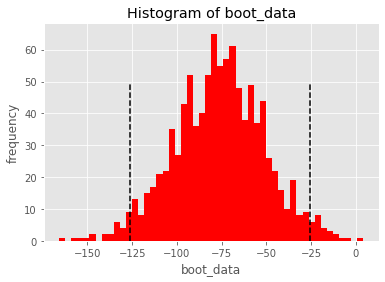

отвергаем нулевую гипотезу


{'quants':                 0
 0.025 -126.152589
 0.975  -25.773532,
 'p_value': 0.002383192959032471}

In [191]:
    get_bootstrap(data2[(data2['segment'] == 'Sweden android male')  \
                                    & (data2['group'] == 'B')].revenue, \
                           data2[(data2['segment'] == 'Sweden android male') \
                                    & (data2['group'] == 'A')].revenue)
        # одинаков ли средний чек в наших группах у мужчин в Швеции, пользующихся андроидом

In [ ]:
# видно, что статистически занчимо отличаются. Здесь в группе В средний чек меньше

In [177]:
data2.groupby(['segment','group']).CR.sum() 
# посмотрели, что данных достаточно для того чтобы попытаться статитстически оценить

segment                group
Russia android female  A        11.0
                       B        49.0
Russia android male    A         8.0
                       B        54.0
Russia ios female      A        13.0
                       B        45.0
Russia ios male        A        11.0
                       B        49.0
Sweden android female  A         6.0
                       B        33.0
Sweden android male    A        14.0
                       B        33.0
Sweden ios female      A         7.0
                       B        27.0
Sweden ios male        A         8.0
                       B        24.0
Name: CR, dtype: float64

In [178]:
# Количество наблюдений >30 можно было бы восопользоваться ttest, 
# но будем острожны с интерпретацией https://youtu.be/-zps6hm0nX8?t=2308

In [179]:
for i in set(data2.segment):
    
    stat, p_value = stats.ttest_ind(data2[(data2['segment'] == i) \
                                    & (data2['group'] == 'B')].revenue, \
                           data2[(data2['segment'] == i) \
                                    & (data2['group'] == 'A')].revenue) 
    print(p_value)
    if p_value<0.05:
        print(f"отвергаем нулевую гипотезу, что в сегменте {i} тест не повлиял на средний чек")
    else:
        print(f"принимаем нулевую гипотезу, что в сегменте {i} тест не повлиял на средний чек")

0.020614604781472316
отвергаем нулевую гипотезу, что в сегменте Sweden android male тест не повлиял на средний чек
0.1873198307857641
принимаем нулевую гипотезу, что в сегменте Sweden android female тест не повлиял на средний чек
0.7721988747931634
принимаем нулевую гипотезу, что в сегменте Russia ios female тест не повлиял на средний чек
0.8193837429305708
принимаем нулевую гипотезу, что в сегменте Russia ios male тест не повлиял на средний чек
0.31482163698230214
принимаем нулевую гипотезу, что в сегменте Russia android female тест не повлиял на средний чек
0.06867028380775819
принимаем нулевую гипотезу, что в сегменте Russia android male тест не повлиял на средний чек
0.2484625580744915
принимаем нулевую гипотезу, что в сегменте Sweden ios male тест не повлиял на средний чек
0.21693808252817964
принимаем нулевую гипотезу, что в сегменте Sweden ios female тест не повлиял на средний чек


In [180]:
for i in set(data2.segment):
    
    stat, p_value = stats.mannwhitneyu(data2[(data2['segment'] == i) \
                                    & (data2['group'] == 'B')].revenue, \
                           data2[(data2['segment'] == i) \
                                    & (data2['group'] == 'A')].revenue) 
    print(p_value)
    if p_value<0.05:
        print(f"отвергаем нулевую гипотезу, что в сегменте {i} тест не повлиял на средний чек")
    else:
        print(f"принимаем нулевую гипотезу, что в сегменте {i} тест не повлиял на средний чек")

0.07823363687743075
принимаем нулевую гипотезу, что в сегменте Sweden android male тест не повлиял на средний чек
0.47388462343638793
принимаем нулевую гипотезу, что в сегменте Sweden android female тест не повлиял на средний чек
0.09663603645769095
принимаем нулевую гипотезу, что в сегменте Russia ios female тест не повлиял на средний чек
0.9143618478208041
принимаем нулевую гипотезу, что в сегменте Russia ios male тест не повлиял на средний чек
0.9929736672251688
принимаем нулевую гипотезу, что в сегменте Russia android female тест не повлиял на средний чек
0.4525691846525963
принимаем нулевую гипотезу, что в сегменте Russia android male тест не повлиял на средний чек
0.8555290983020559
принимаем нулевую гипотезу, что в сегменте Sweden ios male тест не повлиял на средний чек
0.6995728989934811
принимаем нулевую гипотезу, что в сегменте Sweden ios female тест не повлиял на средний чек


In [181]:
# а теперь тоже самое проверим бустрэпом

Sweden android male


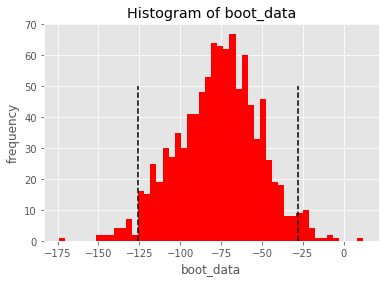

отвергаем нулевую гипотезу
Sweden android female


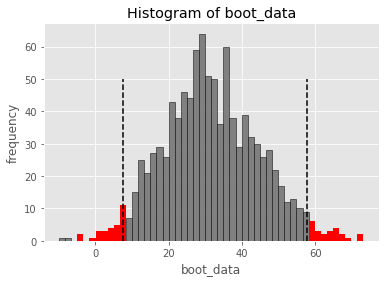

отвергаем нулевую гипотезу
Russia ios female


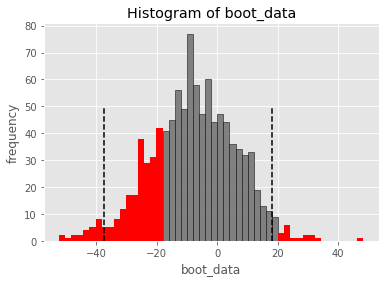

принимаем нулевую гипотезу
Russia ios male


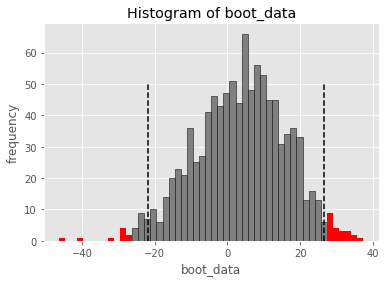

принимаем нулевую гипотезу
Russia android female


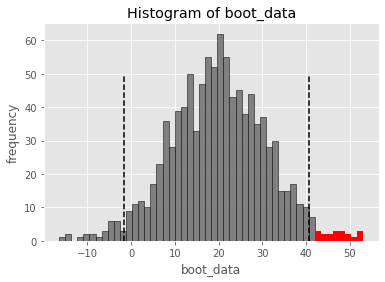

принимаем нулевую гипотезу
Russia android male


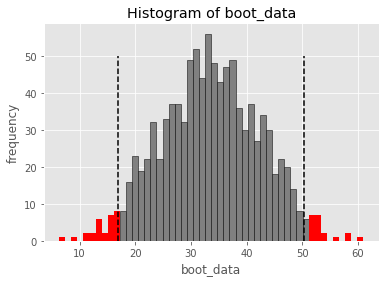

отвергаем нулевую гипотезу
Sweden ios male


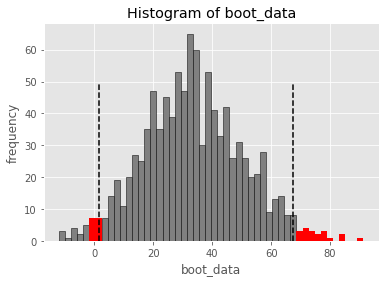

отвергаем нулевую гипотезу
Sweden ios female


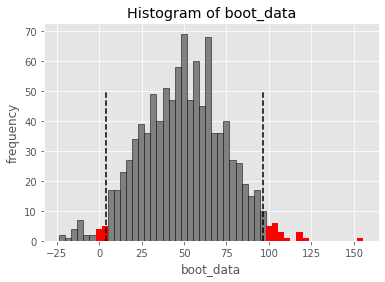

отвергаем нулевую гипотезу


In [182]:
for i in set(data2.segment):
    print(i)
    get_bootstrap(data2[(data2['segment'] == i) \
                                    & (data2['group'] == 'B')].revenue, \
                           data2[(data2['segment'] == i) \
                                    & (data2['group'] == 'A')].revenue)

In [ ]:
Sweden android female
Russia android male
Sweden ios male
Sweden ios female

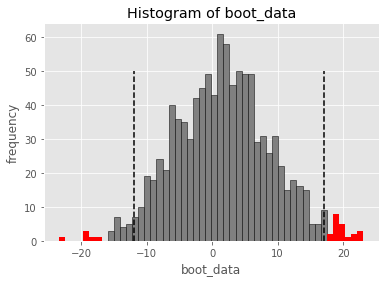

принимаем нулевую гипотезу


{'quants':                0
 0.025 -11.971255
 0.975  17.162430,
 'p_value': 0.8187920478725657}

In [183]:

    get_bootstrap(data2[(data2['sex'] == 'male')  \
                                    & (data2['group'] == 'B')].revenue, \
                           data2[(data2['sex'] == 'male') \
                                    & (data2['group'] == 'A')].revenue)
    # одинаков ли средний чек в наших группах у мужчин

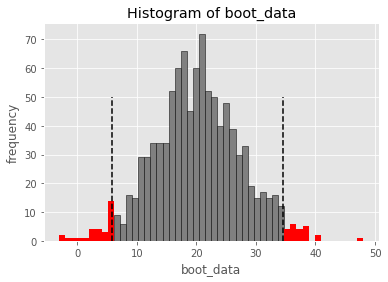

отвергаем нулевую гипотезу


{'quants':                0
 0.025   5.770091
 0.975  34.597185,
 'p_value': 0.005386778836982811}

In [184]:

    get_bootstrap(data2[(data2['sex'] == 'female')  \
                                    & (data2['group'] == 'B')].revenue, \
                           data2[(data2['sex'] == 'female') \
                                    & (data2['group'] == 'A')].revenue)
        # одинаков ли средний чек в наших группах у женщин

In [ ]:
# в группе у женщин В средний чек выше чем в группе А

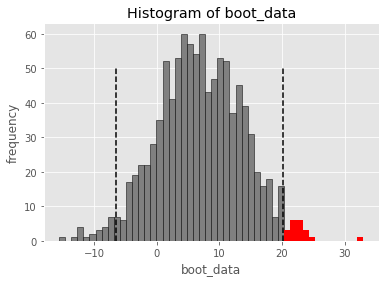

принимаем нулевую гипотезу


{'quants':                0
 0.025  -6.508410
 0.975  20.103281,
 'p_value': 0.306521720462435}

In [185]:

    get_bootstrap(data2[(data2['platform'] == 'android')  \
                                    & (data2['group'] == 'B')].revenue, \
                           data2[(data2['platform'] == 'android') \
                                    & (data2['group'] == 'A')].revenue)
        # одинаков ли средний чек в наших группах у пользователей андроид

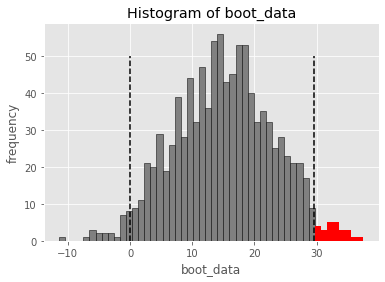

принимаем нулевую гипотезу


{'quants':                0
 0.025  -0.000597
 0.975  29.577470,
 'p_value': 0.05454264580961445}

In [186]:

    get_bootstrap(data2[(data2['platform'] == 'ios')  \
                                    & (data2['group'] == 'B')].revenue, \
                           data2[(data2['platform'] == 'ios') \
                                    & (data2['group'] == 'A')].revenue)
     # одинаков ли средний чек в наших группах у пользователей ios

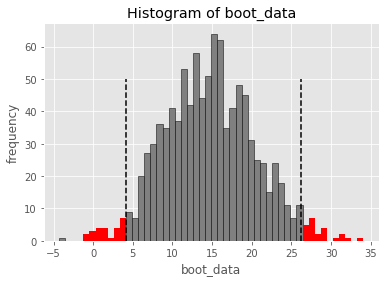

отвергаем нулевую гипотезу


{'quants':                0
 0.025   4.107163
 0.975  26.155337,
 'p_value': 0.010355090038255686}

In [187]:

    get_bootstrap(data2[(data2['country'] == 'Russia')  \
                                    & (data2['group'] == 'B')].revenue, \
                           data2[(data2['country'] == 'Russia') \
                                    & (data2['group'] == 'A')].revenue)
    # одинаков ли средний чек в наших группах у пользователей в России

In [ ]:
# в  России в группе В средний чек выше чем в группе А

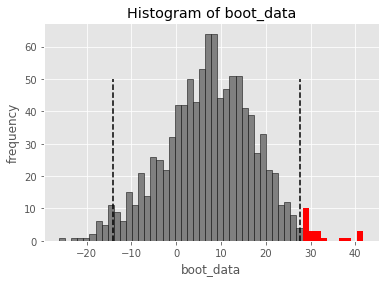

принимаем нулевую гипотезу


{'quants':                0
 0.025 -14.034617
 0.975  27.606415,
 'p_value': 0.46804329175215076}

In [189]:
    get_bootstrap(data2[(data2['country'] == 'Sweden')  \
                                    & (data2['group'] == 'B')].revenue, \
                           data2[(data2['country'] == 'Sweden') \
                                    & (data2['group'] == 'A')].revenue)
        # одинаков ли средний чек в наших группах у пользователей в Швеции

In [ ]:
# Мы видим, что Швеция отличается по поведению пользователей. В швеции группе B средний чек выше 
# чем у дургих пользователей, при не изменившемся переходе в платящие пользователи
# при этом средний чек и переход в платящие пользователи в контрольной групе не изменился
# Это дает понять, что сплитование на группы у нас прошло относительно нормально, но влияние на средний чек 
# нашего АВ теста в швеции оказалось большее чем в России

In [ ]:
# Вывод
# У нас есть149 пользователей не совершивгшие покупку в приложении и не попавших нормально в АВ тест,
# у них другое поведение, чем у пользователей в приложении, их чеки меньше.
# У них не наблюдается различия по поведению между А и В группой
# У нас не равномерно разбиты на группы. В швеции,чуть больше людей попало в А группу
# Мы проверили, что это не повлияло на конверсию и средний чек в контрольной группе, поэтому мы должны изучить 
# почему это произошло, но можем продолжить исследовать АВ тест

# Из-за не нормлаьности распределения использовали бутстрап.
# Даннные показывают, что в группе В статистически значимо выше средний чек чем в группе А,
# при этом конверсия в покупателей статистически значимо не изменилась.
# При этом для пользователей мужчин андроида из Швеции в группе А больше средний чек,
# Но на это может влиять не большое количество больших чеков, в этой группе.

# В целом тест показал положительный результат, но необходимо дальнейшее исследование
# Нужно впервую очередь изучить почему такая большая разница в Швеции у мужчин.
# Во вторых больше положительных изменений заметны у пользователей андроида и практически не очевидны у пользователей ios,
# на это тоже стоит обратить внимание

In [ ]:
# Задание 2

In [ ]:
# По имеющимся данным мы можем собрать только дашборд показывающий конверсию пользователей, за время
# проведения эксперимента

# Вот не большой дашборд собранный из того что есть, чтобы дать общую информацию руководителю

# https://public.tableau.com/app/profile/alex5716/viz/Project_4_16450285692970/Dashboard1?publish=yes

In [ ]:
# В идеале на дашборде должно быть:

# Впервую очередь на дашборде мы отразим изменеие DAU, WAU, MAU

# Потом нам надо будет замерять в динамике действия пользователей в нашем приложении. Нам нужно изменение основных 
# действий пользователей в сумме и в среднем на одного пользователя, а так же смотреть CTR.

# Следующий аспект это retention, churn rate, мы должны наблюдать динамику по ним.

# Следующие аспект, который мы бы хотели учитывать, это источники трафика, откуда приходят наши пользователи, желательно 
# с разбивкой по тратам на привлечение, если таковая отслеживается, чтобы мы всегда видели эти траты.

# Приэтом эти данные лучше для наглядности разбить на динамику по дням и динамику за последний период(неделя, месяц).


# Я собирал уже подходящие дашборды для суимулятора в суперсете:
    
# https://superset.lab.karpov.courses/superset/dashboard/326/
    
# https://superset.lab.karpov.courses/superset/dashboard/325/